<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Employment_and_unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
from numba import jit, jitclass, float64
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

In [3]:
class LakeModelModified:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.

    Parameters:
    ------------
    λ : scalar
        The job finding rate for currently unemployed workers
    α : scalar
        The dismissal rate for currently employed workers
    b : scalar
        Entry rate into the labor force
    d : scalar
        Exit rate from the labor force

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self._λ, self._α, self._b, self._d = λ, α, b, d
        self.compute_derived_values()

    def compute_derived_values(self):
        # Unpack names to simplify expression
        λ, α, b, d = self._λ, self._α, self._b, self._d

        self._g = b - d
        self._A = np.array([[(1-d) * (1-λ) + b, (1 - d) * α + b],
                   [     (1-d) * λ, (1 - d) * (1 - α)]])

        self._A_hat = self._A / (1 + self._g)

    @property
    def g(self):
        return self._g

    @property
    def A(self):
        return self._A

    @property
    def A_hat(self):
        return self._A_hat

    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._λ = new_value
        self.compute_derived_values()

    @property
    def α(self):
        return self._α

    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, new_value):
        self._b = new_value
        self.compute_derived_values()

    @property
    def d(self):
        return self._d

    @d.setter
    def d(self, new_value):
        self._d = new_value
        self.compute_derived_values()


    def rate_steady_state(self, tol=1e-6):
        """
        Finds the steady state of the system :math:`x_{t+1} = \hat A x_{t}`

        Returns
        --------
        xbar : steady state vector of employment and unemployment rates
        """
        x = 0.5 * np.ones(2)
        error = tol + 1
        while error > tol:
            new_x = self.A_hat @ x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):
        """
        Simulates the sequence of Employment and Unemployment stocks

        Parameters
        ------------
        X0 : array
            Contains initial values (E0, U0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        X : iterator
            Contains sequence of employment and unemployment stocks
        """

        X = np.atleast_1d(X0)  # Recast as array just in case
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        Simulates the sequence of employment and unemployment rates

        Parameters
        ------------
        x0 : array
            Contains initial values (e0,u0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        x : iterator
            Contains sequence of employment and unemployment rates

        """
        x = np.atleast_1d(x0)  # Recast as array just in case
        for t in range(T):
            yield x
            x = self.A_hat @ x

## Exercise 2

In [4]:
N = 100
T = 50
lmm = LakeModelModified()
x0 = lmm.rate_steady_state()
x0_stock = x0*100
lmm.λ = 0.2
rate_path = np.vstack(tuple(lmm.simulate_rate_path(x0, T)))
x_bar = lmm.rate_steady_state()
stock_path = np.vstack(tuple(lmm.simulate_stock_path(x0_stock, T)))

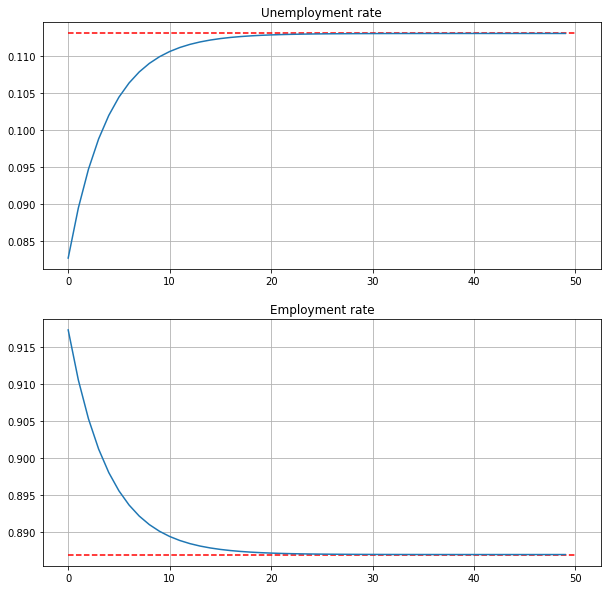

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax, val, title, eq in zip(axes.flatten(), rate_path.T, ['Unemployment', 'Employment'], x_bar):
  ax.plot(val)
  ax.set(title=title + " rate")
  ax.hlines(eq, 0, T, 'r', '--')
  ax.grid();

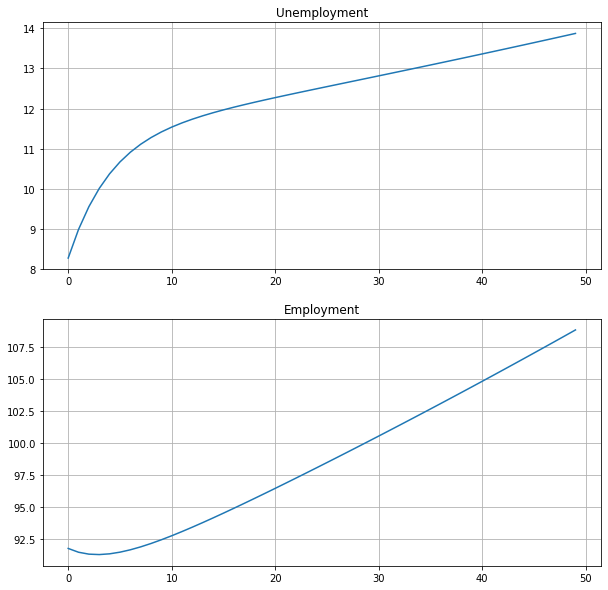

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax, val, title in zip(axes.flatten(), stock_path.T, ['Unemployment', 'Employment']):
  ax.plot(val)
  ax.set(title=title)
  ax.grid();

## Exercise 3

In [15]:
N = 100
T = 50
K = 20
lmm = LakeModelModified()
b_origin = lmm.b
x0 = lmm.rate_steady_state()

x0_stock = x0*100
lmm.b = 0.025
rate_path_before = np.vstack(tuple(lmm.simulate_rate_path(x0, K)))
stock_path_before = np.vstack(tuple(lmm.simulate_stock_path(x0_stock, K)))

lmm.b = b_origin
rate_path_after = np.vstack(tuple(lmm.simulate_rate_path(rate_path_before[-1], T-K+1)))
stock_path_after = np.vstack(tuple(lmm.simulate_stock_path(stock_path_before[-1], T-K+1)))

rate_path = np.vstack((rate_path_before, rate_path_after[1:]))
stock_path = np.vstack((stock_path_before, stock_path_after[1:]))

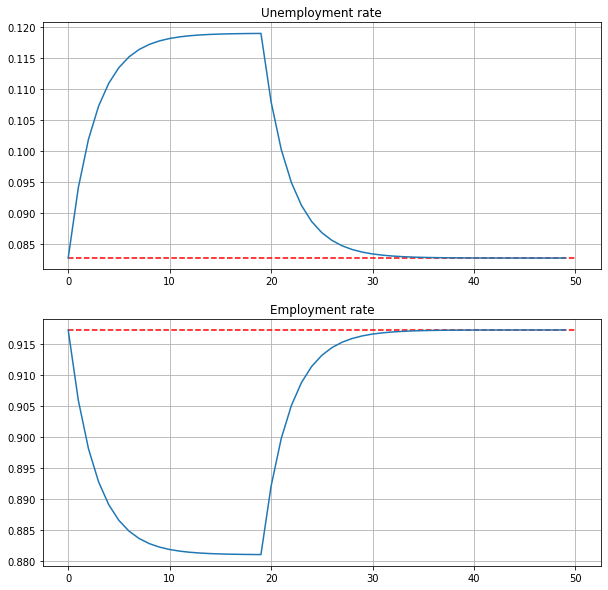

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax, val, title, eq in zip(axes.flatten(), rate_path.T, ['Unemployment', 'Employment'], x0):
  ax.plot(val)
  ax.set(title=title + " rate")
  ax.hlines(eq, 0, T, 'r', '--')
  ax.grid();

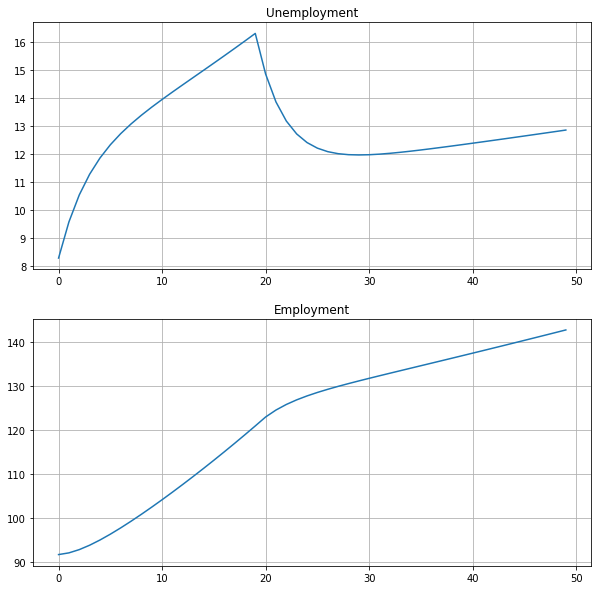

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax, val, title in zip(axes.flatten(), stock_path.T, ['Unemployment', 'Employment']):
  ax.plot(val)
  ax.set(title=title)
  ax.grid();